## Import everything

In [3]:
%reload_ext autoreload

%autoreload 2

import os.path as osp
from omegaconf.omegaconf import OmegaConf
import logging 
logging.getLogger().setLevel(logging.ERROR)

import sys
sys.path.append('externals/frankmocap/')
sys.path.append('externals/frankmocap/detectors/body_pose_estimator/')

from config.defaults import get_cfg_defaults

from nnutils.hand_utils import ManopthWrapper
from nnutils.handmocap import get_handmocap_predictor, process_mocap_predictions, get_handmocap_detector
from nnutils.hoiapi import vis_hand_object, Predictor
from nnutils import model_utils
from jutils import image_utils

from externals.frankmocap.mocap_utils.demo_utils import extract_mesh_from_output

import numpy as np
from PIL import Image

from renderer.screen_free_visualizer import Visualizer


## Loading an image

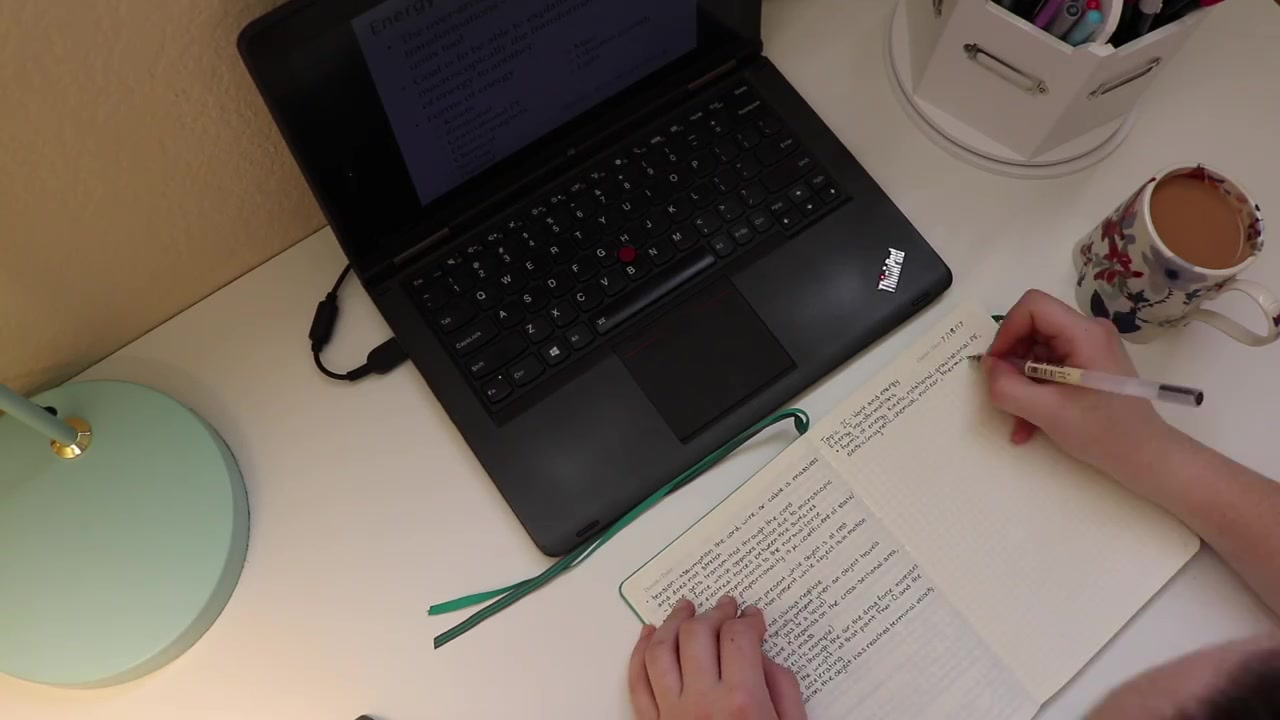

In [4]:
# read in an image
filename = 'demo/test.jpg'
image_pil = Image.open(filename).convert("RGB")
image = np.array(image_pil)
image_pil



## Estimate Hand
Estimate hand pose by frankmocap and preprocess the output to be consumed by IHOI model.

Loading Body Pose Estimator
Loading Ego Centric Hand Detector


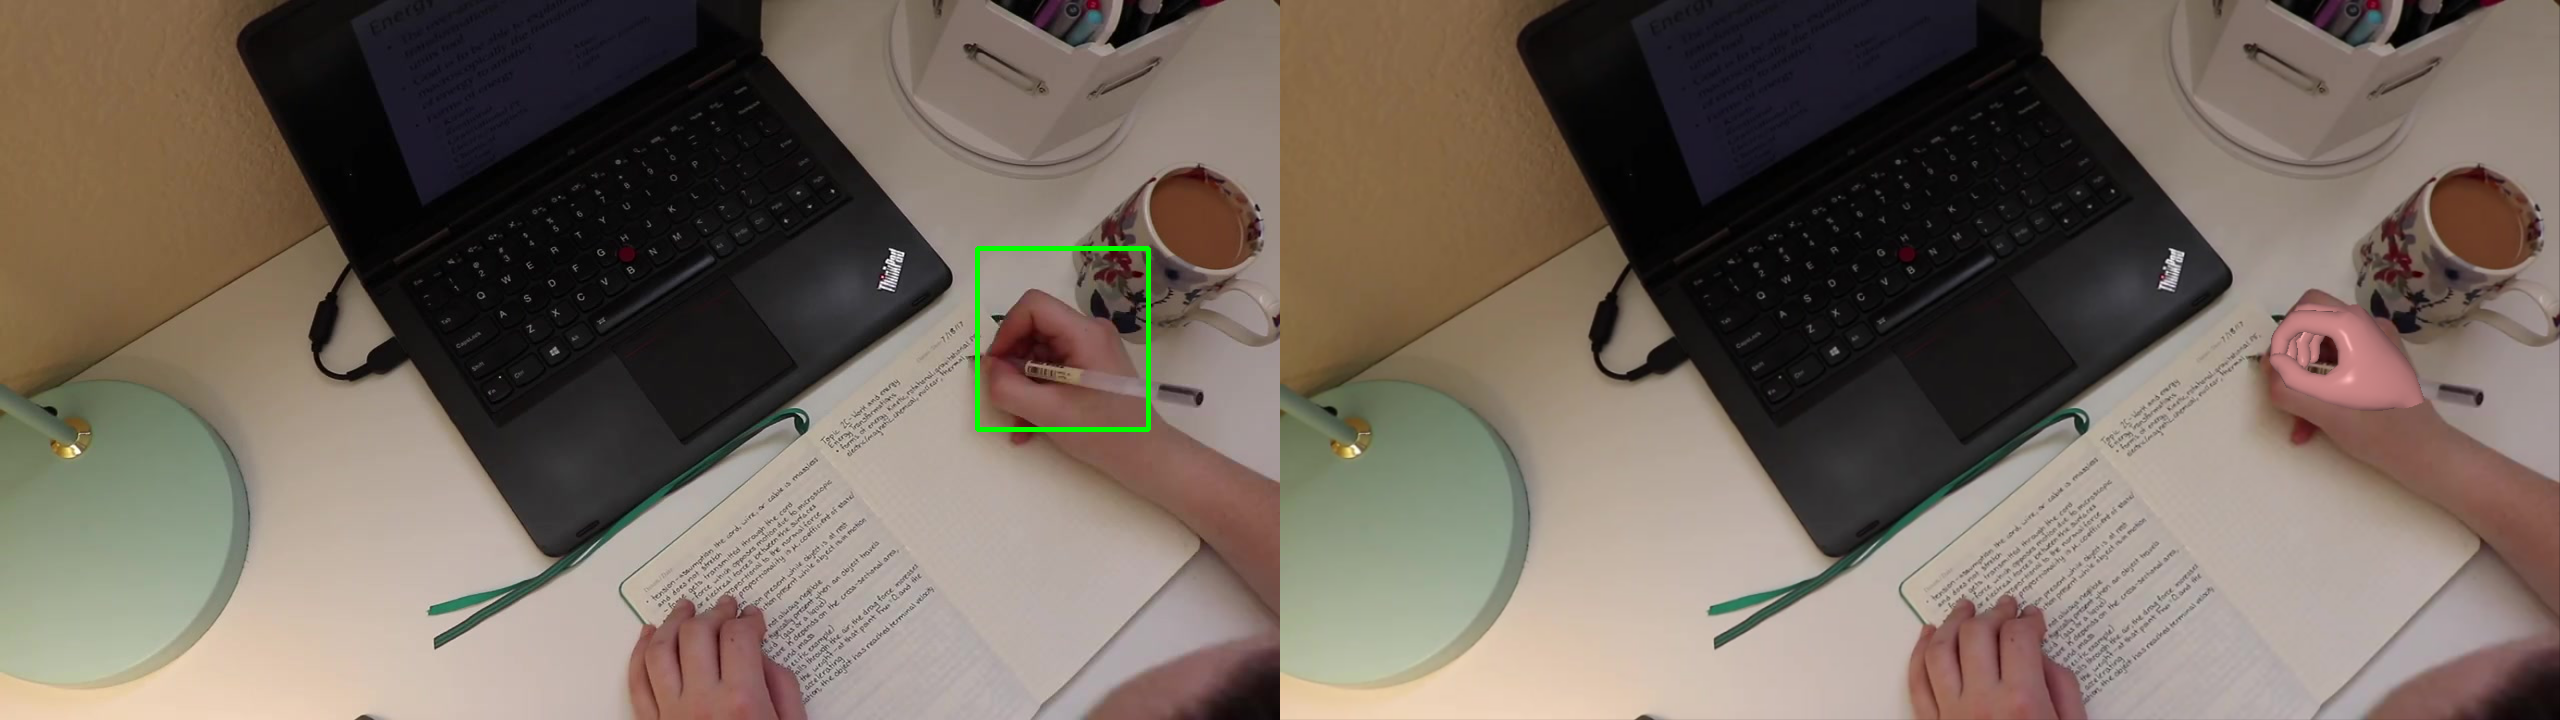

In [5]:

visualizer = Visualizer('pytorch3d')

bbox_detector = get_handmocap_detector()
# Process Human Estimations.
detect_output = bbox_detector.detect_hand_bbox(image[::-1].copy())
body_pose_list, body_bbox_list, hand_bbox_list, raw_hand_bboxes = detect_output

hand_predictor = get_handmocap_predictor()
mocap_predictions = hand_predictor.regress(
    image[..., ::-1], hand_bbox_list
)

hand_wrapper = ManopthWrapper().to('cpu')

visualizer = Visualizer('pytorch3d')
pred_mesh_list = extract_mesh_from_output(mocap_predictions)

# visualize
res_img = visualizer.visualize(
    image, 
    pred_mesh_list = pred_mesh_list, 
    hand_bbox_list = hand_bbox_list)


Image.fromarray(res_img.astype(np.uint8))


In [6]:

def get_hoi_predictor(experiment_directory='/checkpoint/yufeiy2/hoi_output/release_model/mow'):
    cfg_def = get_cfg_defaults()
    cfg_def = OmegaConf.create(cfg_def.dump())
    cfg = OmegaConf.load(osp.join(experiment_directory, 'hparams.yaml'))
    cfg = OmegaConf.merge(cfg_def, cfg)
    cfg.MODEL.BATCH_SIZE = 1
    model = model_utils.load_model(cfg, experiment_directory, 'last')

    predictor = Predictor(model)
    return predictor


In [7]:

data = process_mocap_predictions(
    mocap_predictions, image, hand_wrapper
)

out_dir = './output/'
hoi_predictor = get_hoi_predictor()
output = hoi_predictor.forward_to_mesh(data)


torch.Size([1, 3]) torch.Size([1, 21, 3])


/private/home/yufeiy2/nnutils/src/jutils/mesh_utils.py:1566: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(


save to  ./output//test_cHoi.gif
save meshes to  ./output//test_hoi


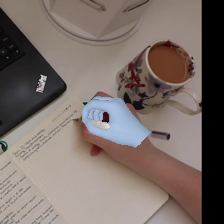

In [15]:
vis_hand_object(output, data, image, out_dir + '/test')
Image.open('output/test_cHoi.png')

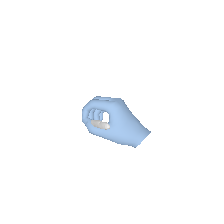

In [16]:
image_utils.display_gif('output/test_cHoi.gif')